#  프로젝트: CAM을 만들고 평가해 보자

#### 평가문항	상세기준
1. CAM을 얻기 위한 기본모델의 구성과 학습이 정상 진행되었는가?  
ResNet50 + GAP + DenseLayer 결합된 CAM 모델의 학습과정이 안정적으로 수렴하였다.  


2. 분류근거를 설명 가능한 Class activation map을 얻을 수 있는가?  
CAM 방식과 Grad-CAM 방식의 class activation map이 정상적으로 얻어지며, 시각화하였을 때 해당 object의 주요 특징 위치를 잘 반영한다.   


3. 인식결과의 시각화 및 성능 분석을 적절히 수행하였는가?  
CAM과 Grad-CAM 각각에 대해 원본이미지합성, 바운딩박스, IoU 계산 과정을 통해 CAM과 Grad-CAM의 object localization 성능이 비교분석되었다.

## * Get data&Preprocess

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [2]:
#위에 만들어진 함수를 통해 데이터셋의 전처리와 배치처리를 적용하자
ds_train_norm =apply_normalize_on_dataset(ds_train)
ds_test_norm =apply_normalize_on_dataset(ds_test)

#구성된 배치의 모양을 확인한다.
for input in ds_train_norm.take(1):
    image,label=input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


## * Set a model to get CAM

In [3]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [4]:
tf.random.set_seed(2021)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)


In [5]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [6]:
#학습시키기
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - 346s 424ms/step - loss: 3.1881 - accuracy: 0.2847 - val_loss: 3.5543 - val_accuracy: 0.1699
Epoch 2/15
750/750 [==============================] - 320s 426ms/step - loss: 0.8769 - accuracy: 0.7529 - val_loss: 1.0689 - val_accuracy: 0.6827
Epoch 3/15
750/750 [==============================] - 321s 428ms/step - loss: 0.3413 - accuracy: 0.9173 - val_loss: 1.0834 - val_accuracy: 0.6883
Epoch 4/15
750/750 [==============================] - 321s 428ms/step - loss: 0.1030 - accuracy: 0.9835 - val_loss: 0.9268 - val_accuracy: 0.7357
Epoch 5/15
750/750 [==============================] - 321s 428ms/step - loss: 0.0317 - accuracy: 0.9981 - val_loss: 0.9291 - val_accuracy: 0.7413
Epoch 6/15
750/750 [==============================] - 331s 442ms/step - loss: 0.0176 - accuracy: 0.9996 - val_loss: 0.9468 - val_accuracy: 0.7425
Epoch 7/15
750/750 [==============================] - 321s 428ms/step - loss: 0.0113 - accuracy: 1.0000 - val_loss: 0.9665 -

In [7]:
import os
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)


In [8]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

In [9]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

## * Generator a CAM image

100


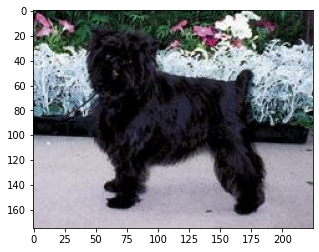

In [10]:
#새로운 이미지 뽑기
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

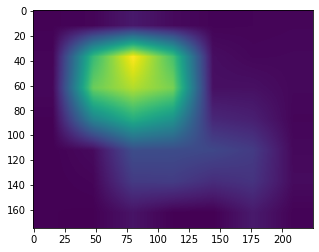

In [11]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

## * Make a method for blending

 원본 이미지와 CAM 이미지를 입력으로 받고 두 개의 이미지의 투명도를 조정, 하나의 이미지에서 원본과 CAM을 겹쳐 보여주는 visualize_cam_on_image() 함수를 만들어보세요.

In [12]:

def visualize_cam_on_image(image, cam_image):
    a=0.6
    width=image.shape[1]
    height=image.shape[0]
    cam_image=cv2.resize(cam_image,(width,height))
    
    b=1.0 - a
    merged_image = cv2.addWeighted(image,a,cam_image,b,0.0)
#     cv.imshow('dst',dst)
#     cv.waitKey(0)
    
#     merged_image = None
    return merged_image

# def visualize_cam_on_image(src1, src2, alpha=0.5):
#     beta = (1.0 - alpha)
#     merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
#     return merged_image



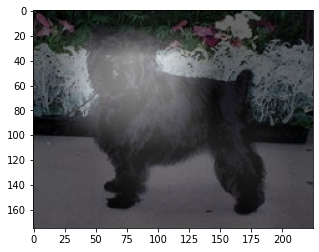

In [13]:
# visualize_cam_on_image() 함수 사용

origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()


## * Implement Grad-CAM

In [14]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)

    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image


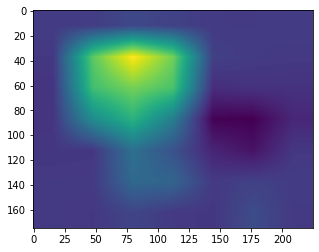

In [15]:
# 만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해 보세요.
grad_cam_image = generate_grad_cam(cam_model,'conv5_block3_out',item)
plt.imshow(grad_cam_image)
plt.show()

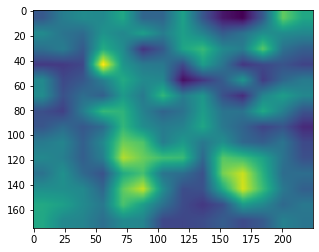

In [16]:
grad_cam_image = generate_grad_cam(cam_model,'conv4_block3_out',item)
plt.imshow(grad_cam_image)
plt.show()

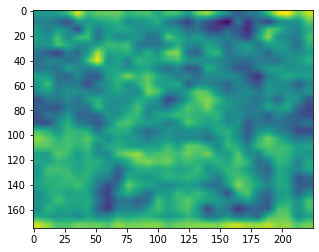

In [17]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

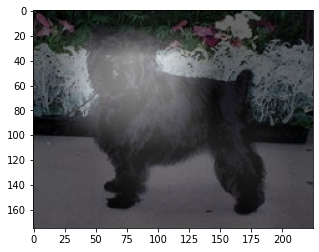

In [18]:
# 위에서 만든 이미지 visualize_cam_on_image() 함수로 이미지를 시각화해 보세요.
grad_cam_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, grad_cam_image)
plt.imshow(blended_image)

## * Bounding Box

In [27]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect


In [28]:
rect = get_bbox(cam_image)
rect

array([[  1, 150],
       [ 24,  -9],
       [218,  18],
       [196, 177]])

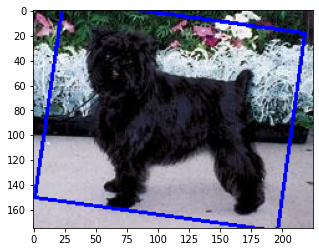

In [29]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

In [30]:
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [31]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[-0.05142857142857143,
 0.0044444444444444444,
 1.0114285714285713,
 0.9688888888888889]

In [32]:
item['objects']['bbox']

array([[0.08      , 0.16444445, 0.94857144, 0.84      ]], dtype=float32)

In [33]:
#두 박스가 얼마나 유사한지 IoU계산
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [34]:
get_iou(pred_bbox,item['objects']['bbox'][0])

0.5724196177863679

#### 결과
0.5 이상이 나오면 제법 유사하다고 볼 수 있는 결과다.

### 정리
Class Activation Map에 관해 배우고 실험해볼 수 있는 시간이었다.  
기존 CNN과 다르게 엔드단에서 FC대신 Global Average pooling연산을 하는 이유와 차이(최적화할 파라미터가 없어 과적합 방지)에 대해 알 수 있었다.  
학습 중간에 ACoL에 관한 논문을 봤으며 이를 통해 약지도학습 기법을 활용해 물체를 검출하는 방법도 알았다.  
IoU 계산법을 통해 두 개의 객체 바운딩 박스의 전체의 합과 교집합을 활용해 얼마나 유사한지 테스트도 할 수 있었다.
